## Robust Principal Component Analysis (RPCA)

> Robust PCA is a technique for decomposing a data matrix into two terms: a low-rank matrix capturing the characteristics of interest and a sparse matrix containing noise that captures the corrupted data.

Standard PCA can be thought of as a maximization problem (maximizing the preserved variance of the data) or a minimization problem (minimizing the squared errors between data and their projection on the principal axes). Using this approach, the solution will be strongly skewed towards the outliers as they use an $L2$-norm, making the solution sensitive to outliers (not robust). That is to say, PCA is a fragile approach that will fail when your data is either corrupted or incomplete. An answer to this dilemma was developed by Candes, Li, Ma, and Wright in their 2009 paper _"Robust Principal Component Analysis?"_ (see __[1]__ in __References__).

Like Sparse PCA (see my [notebook on Sparse PCA](../sparsePCA/sparsePCA.ipynb)), there are multiple approaches to solving this problem. This notebook will only set up the problem and refer the reader to specifics on theory and derivation.

Given a data matrix $X \in R^{m \times n}$ with $n$ data samples, we wish to decompose it as the sum of a low-rank matrix $L$ and a sparse matrix $S$: $$X = L+S$$

Here, $X$ contains our corrupted data, $L$ is of low rank and contains our corrected data, and $S$ will hold all the outlier measurements. Given this decomposition, $L$ will be a new dataset we can work with that will be well-approximated by standard PCA or other machine learning algorithms. Mathematically, this (idealized) problem can be written as $$\underset{L, S}{min}\;\;\{rank(L)+||S||_0\}\;\;s.t.\;\;X = L+S$$

This problem is intractable as neither component is convex and there is no guarantee to a solution. To solve this, a convex relaxation is introduced using proxies for the actual operators of interest. The rank is replaced by the _nuclear norm_ (the sum of singular values - more zero singular values means lower rank) and the $0$-norm is replaced by the $1$-norm (sum of absolute values).

$$\underset{L, S}{min}\;\;\{||L||_{*}+\lambda||S||_1\}\;\;s.t.\;\;X = L+S$$


The above formulation's solution converges to the idealized formulation with high probability providing $\lambda =  \frac{1}{\sqrt{max(n,m)}}$ (see __[2]__).

From this point, the method of Augmented Lagrange Multipliers can be applied (__[3]__) to find the desired decomposition. Per __[2]__, you can also utilize the Alternating Directions Method (ADM) by applying a shrinkage operator and a Singular Value Threshold (SVT) operator iteratively. The following code block defining the functions `shrink`, `SVT`, and _RPCA_ is provided by __[2]__ and all credit goes to Steven L. Brunton, J. Nathan Kutz, and Daniel Dylewsky (for translating the original MATLAB code to Python) for these functions. We apply the results from the aformentioned functions to a problem involving denoising handwritten digits to illustrate the power of RPCA. Besides the example I will demonstrate in this ntoebook, __[2]__ contains interesting applications to the fields of face recognition and reconstruction, common applications of RPCA.

After _RPCA_ is performed on a dataset, we will analyze how well the data was cleaned up. Further, we will draw samples from our test set and see what our 'learned' representation reveals about noisy unknown samples. This is the step where classification or face recognition might apply. 

Mathematically, we project the new test sample (image) onto the cleaned data matrix $L$, which represent our 'eigen-digits'. Depending on the number of samples and image size, this represents a system of equations $L\vec{x} = \vec{b}$ with $\vec{b}$ being a column vector equal in length to the number of pixels and $L$ have as many rows as the number of pixels in an image and columns as number of samples. We are projecting the vector $\vec{b}$ onto the columns (images) of $L$, and that will either be an overdetermined or underdetermined system. To determine the solution, we will utilize the Moore-Penrose pseudoinverse of $L$. In the underdetermined case ($L$ has more oclumns than rows), we will obtain thesmallest approximation to the solution in the 2-norm sense. In the overdetermined case ($L$ has more rows than columns), we will obtain the best solution in a least squared error sense.

If $L = U\Sigma V^T$ (from the SVD), then the pseudoinverse is calculated as $L^+ = V \Sigma^+ V^T$. Here, $\Sigma^+$ is constructed by replacing the non-zero diagonal elements of $\Sigma$ by their recipricols. So, our projection componenets becomes $L^+ \vec{b}$, and hence we can reconstruct the cleaned sample as $L L^+\vec{b}$.

In [27]:
# Imports
import os

import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.datasets as tfds
from sklearn.model_selection import StratifiedShuffleSplit

In [28]:
# RPCA from Steven L. Brunton; J. Nathan Kutz (2019)
# Available from Ch.3 Sec.7 at http://databookuw.com/CODE_PYTHON.zip
def shrink(X,tau):
    Y = np.abs(X)-tau
    return np.sign(X) * np.maximum(Y,np.zeros_like(Y))
    
def SVT(X,tau):
    U,S,VT = np.linalg.svd(X,full_matrices=0)
    out = U @ np.diag(shrink(S,tau)) @ VT
    return out
    
def RPCA(X):
    n1,n2 = X.shape
    mu = n1*n2/(4*np.sum(np.abs(X.reshape(-1))))
    lambd = 1/np.sqrt(np.maximum(n1,n2))
    thresh = 10**(-7) * np.linalg.norm(X)
    
    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    L = np.zeros_like(X)
    count = 0
    while (np.linalg.norm(X-L-S) > thresh) and (count < 1000):
        L = SVT(X-S+(1/mu)*Y,1/mu)
        S = shrink(X-L+(1/mu)*Y,lambd/mu)
        Y = Y + mu*(X-L-S)
        count += 1
    return L,S

__Application__

In order to illustrate the reconstruction abilities of RPCA, we will add noise to, then remove said noise from, samples of the well-known Modified National Institute of Standards and Technology (MNIST, __[4]__) handwritten digits dataset. The images are of type $uint8$ and normalized from $0$ to $255$ initially, though we will normalize the data from $0$ to $1$. We will use the dataset provided by the _TensorFlow_ package in Python. First, we load in training and testing images of the digits 0 through 9. Note I use 10 samples per class for testing (100 total testing samples). This is fairly small but will be sufficient to demonstrate the technique.

In [29]:
# Specify size of training and testing sets, 10 classes of digits (0 through 9)
n_tr_samples_per_class = 30 # Approximate after random selection.
n_te_samples_per_class = 10 # Approximate after random selection.

# Load in the data from TensorFlow
(x_train, y_train), (x_test, y_test) = tfds.mnist.load_data()

# First, we will reduce the training and testing set to a manageable number
# while maintaining roughly even class splits
sss_tr = StratifiedShuffleSplit(n_splits = 1,
                                train_size = n_tr_samples_per_class*10)

for sample_index, _ in sss_tr.split(x_train, y_train):
    X_tr = x_train[sample_index]
    y_tr = y_train[sample_index]
    
unique_tr_classes, tr_class_counts = np.unique(y_tr, return_counts = True)
tr_class_counts_df = pd.DataFrame({'class':unique_tr_classes, 'counts': tr_class_counts})
print('Training data:\n', tr_class_counts_df)

sss_te = StratifiedShuffleSplit(n_splits = 1,
                                train_size = n_te_samples_per_class*10)

for sample_index, _ in sss_te.split(x_test, y_test):
    X_te = x_test[sample_index]
    y_te = y_test[sample_index]
    
unique_te_classes, te_class_counts = np.unique(y_te, return_counts = True)
te_class_counts_df = pd.DataFrame({'class':unique_te_classes, 'counts': te_class_counts})
print('Testing data:\n', te_class_counts_df)

Training data:
    class  counts
0      0      30
1      1      34
2      2      30
3      3      31
4      4      29
5      5      27
6      6      29
7      7      31
8      8      29
9      9      30
Testing data:
    class  counts
0      0      10
1      1      11
2      2      10
3      3      10
4      4      10
5      5       9
6      6      10
7      7      10
8      8      10
9      9      10


Let's explore the training data a little. 

Training data array has shape:  (300, 28, 28)
Testing data array has shape:  (100, 28, 28)
Data is type:  uint8
Data max:  255
Data min:  0
The labels are:  [0 1 2 3 4 5 6 7 8 9]


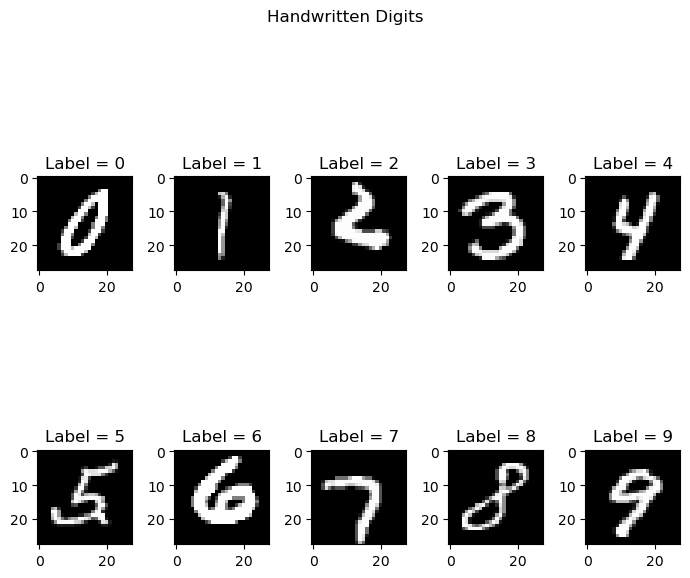

In [30]:
print('Training data array has shape: ', X_tr.shape)
print('Testing data array has shape: ', X_te.shape)
print('Data is type: ', X_tr.dtype)
print('Data max: ', X_tr.max())
print('Data min: ', X_tr.min())
print('The labels are: ', np.unique(y_tr))

# Plot a sample from each class in the training set.
fig, axs = plt.subplots(2, 5, figsize=(7, 7))
axs = axs.flatten()
plt.suptitle('Handwritten Digits')
for label, ax in zip(np.unique(y_tr), axs):
    ix = np.where(y_tr == label)[0][0]
    ax.set_title(f'Label = {label}')
    ax.imshow(X_tr[ix], cmap = 'gray')
fig.tight_layout()
plt.show()

When viewing these, it's not difficult to see what digits the images contain. To simulate a real-world scenario in which the data is corrupted, we will need to add some noise and confusion. The following function will be applied to the training and testing images to corrupt the imagery. It will add some gaussan noise, salt and pepper noise, and random rectangular-region deletion.

In [31]:
def corrupt_image(image,
                  salt_perc = 0.07,
                  pepper_perc = 0.07,
                  rect_max_dim = 12):
    
    '''
    This function will add noise to an image in three ways:
        1. Salt and pepper noise.
        2. Gaussian noise.
        3. Block sized pixel removal.
        
    Args:
    - image: The image as a 2-D Numpy array (single band).
    - salt_prob: The percentage of total pixels to be turned to 1.
    - pepper_prob: The percentage of total pixels to be turned to 0.
    - rect_max_dim: The maximum length or width of the randomly deleted regions (pixels set to 0).
    '''
    
    image_copy = np.copy(image)
    total_pixels = image_copy.size

    # With 80% probability, add salt and pepper noise.
    if np.random.uniform() > 0.2:
        # Add salt noise.
        num_salt = np.ceil(salt_perc * total_pixels)
        coords_salt = [np.random.randint(0, i - 1, int(num_salt)) for i in image_copy.shape]
        image_copy[coords_salt[0], coords_salt[1]] = image_copy.max()
    
        # Add pepper noise.
        num_pepper = np.ceil(pepper_perc * total_pixels)
        coords_pepper = [np.random.randint(0, i - 1, int(num_pepper)) for i in image_copy.shape]
        image_copy[coords_pepper[0], coords_pepper[1]] = image_copy.min()
        
    # With 80% probability, add gaussian noise. This uses a standard deviation of 10% of the pixel value range.
    if np.random.uniform() > 0.2:
        gaussian_noise = np.random.normal(0, 0.1*(image_copy.max() - image_copy.min()), image_copy.shape)
        image_copy = image_copy + gaussian_noise
        
    # With 80% probability, remove a rectangular block of pixels (set to 0).
    # The height and width will range from 1 to rect_max_dim randomly.
    if np.random.uniform() > 0.2:
        # Pick a starting coordinate for the rectangular block.
        y_upper_left = np.random.randint(0, image_copy.shape[0] - rect_max_dim)
        x_upper_left = np.random.randint(0, image_copy.shape[1] - rect_max_dim)

        # Randomly choose a height and width.
        h, w = np.random.randint(1, rect_max_dim, 2)

        y_end = min(y_upper_left + h, image_copy.shape[0] - 1) # Should be fine, but just in case.
        x_end = min(x_upper_left + w, image_copy.shape[1] - 1)
        
        image_copy[y_upper_left:y_end, x_upper_left:x_end] = image_copy.min()
        
    return image_copy

Apply this function to the training and testing sets and visualize the first three training images and their augmented counterparts. Additionally, we will normalize the data from $0$ to $1$. Feel free to experiment with the noise parameters above.

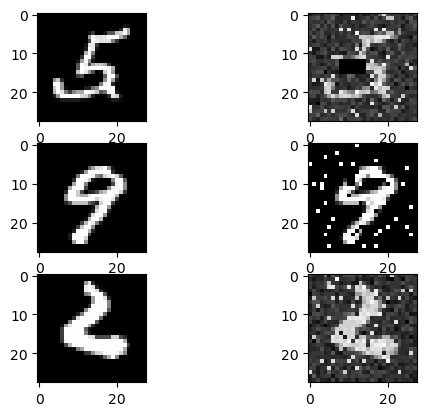

In [32]:
X_tr_aug = np.array([corrupt_image(img) for img in X_tr])
X_te_aug = np.array([corrupt_image(img) for img in X_te])

# Normalize the data from 0 to 1.
tr_mins = X_tr_aug.min(axis = (1, 2), keepdims=True)
tr_maxs = X_tr_aug.max(axis = (1, 2), keepdims=True)
X_tr_scaled = (X_tr_aug - tr_mins)/(tr_maxs - tr_mins)

te_mins = X_te_aug.min(axis = (1, 2), keepdims=True)
te_maxs = X_te_aug.max(axis = (1, 2), keepdims=True)
X_te_scaled = (X_te_aug - te_mins)/(te_maxs - te_mins)

f, axarr = plt.subplots(3,2)
axarr[0,0].imshow(X_tr[0], cmap = 'gray')
axarr[0,1].imshow(X_tr_scaled[0], cmap = 'gray')
axarr[1,0].imshow(X_tr[1], cmap = 'gray')
axarr[1,1].imshow(X_tr_scaled[1], cmap = 'gray')
axarr[2,0].imshow(X_tr[2], cmap = 'gray')
axarr[2,1].imshow(X_tr_scaled[2], cmap = 'gray')
plt.show()

As an additional step, let's reshape the data arrays to be $m \times n$ with $n = 10000$ and $m = 28\times28$. We will then order the images by increasing label; the first (approximately) 1000 columns will be in class 0, the next roughly 1000 columns in class 1, and so on. The same process is done for the label arrays themselves.

In [33]:
# This places the images as columns as described above.
X_tr_col = X_tr_scaled.reshape(X_tr_scaled.shape[0], -1).T
X_te_col = X_te_scaled.reshape(X_te_scaled.shape[0], -1).T

# This organizes by increasing class.
ordered_columns_tr = np.argsort(y_tr)
X_tr_org = X_tr_col[:,ordered_columns_tr]

ordered_columns_te = np.argsort(y_te)
X_te_org = X_te_col[:,ordered_columns_te]

y_tr_org = y_tr[ordered_columns_tr]
y_te_org = y_te[ordered_columns_te]

print(X_tr_org.shape)

(784, 300)


The variable $X\_tr\_org$ represents our data matrix $X$ described in the introduction. Before applying _RPCA_, we will mean-center the data. Then, we will add the mean back in to the returned $L$ matrix. This will allow us to observe RPCA's performance on the training set. Note the algorithm can take significantly longer should the training set become too large.

In [34]:
X_mean = X_tr_org.mean(axis=1, keepdims=True)
X_centered = X_tr_org - X_mean
L_centered, S = RPCA(X_centered)
L = L_centered + X_mean

Now, let's look at five randomly chosen training samples. The original will be on the left, and the corresponsing reconstruction on the right. This cell can be repeatedly ran to visualize different samples.

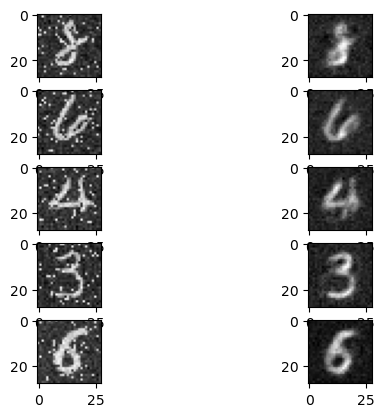

In [35]:
# Pick three indices at random from the training set.
inds = np.random.randint(0, X_tr_org.shape[1] - 1, 5)

f, axarr = plt.subplots(5,2)
for ix, ind in enumerate(inds):
    axarr[ix,0].imshow(X_tr_org[:,ind].reshape((28,28)), cmap = 'gray')
    axarr[ix,1].imshow(L[:,ind].reshape((28,28)), cmap = 'gray')
plt.show()

Finally, we will try out the algorithm described in the introduction on some test samples and plot them as above. First, the data will be mean-centered and the centered $L$ matrix used to project the test data onto the new basis. Second, the mean will be added back in for visualization.

In [36]:
test_data_centered = X_te_org - X_mean
components = np.linalg.pinv(L_centered) @ test_data_centered
centered_test_results = L_centered @ components
test_results = centered_test_results + X_mean

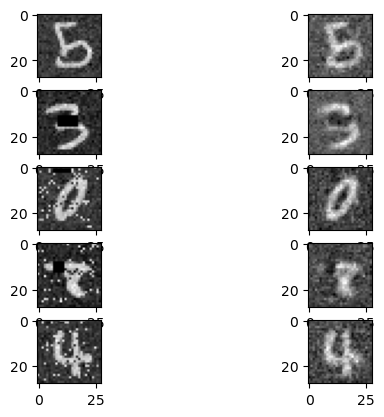

In [39]:
inds = np.random.randint(0, X_te_org.shape[1] - 1, 5)

f, axarr = plt.subplots(5,2)
for ix, ind in enumerate(inds):
    axarr[ix,0].imshow(X_te_org[:,ind].reshape((28,28)), cmap = 'gray')
    axarr[ix,1].imshow(test_results[:,ind].reshape((28,28)), cmap = 'gray')
plt.show()

As a final note, it may be useful inspecting the components above for the purpose of classification. Let's take a digit we know the label of and visualize the components as a bar chart.

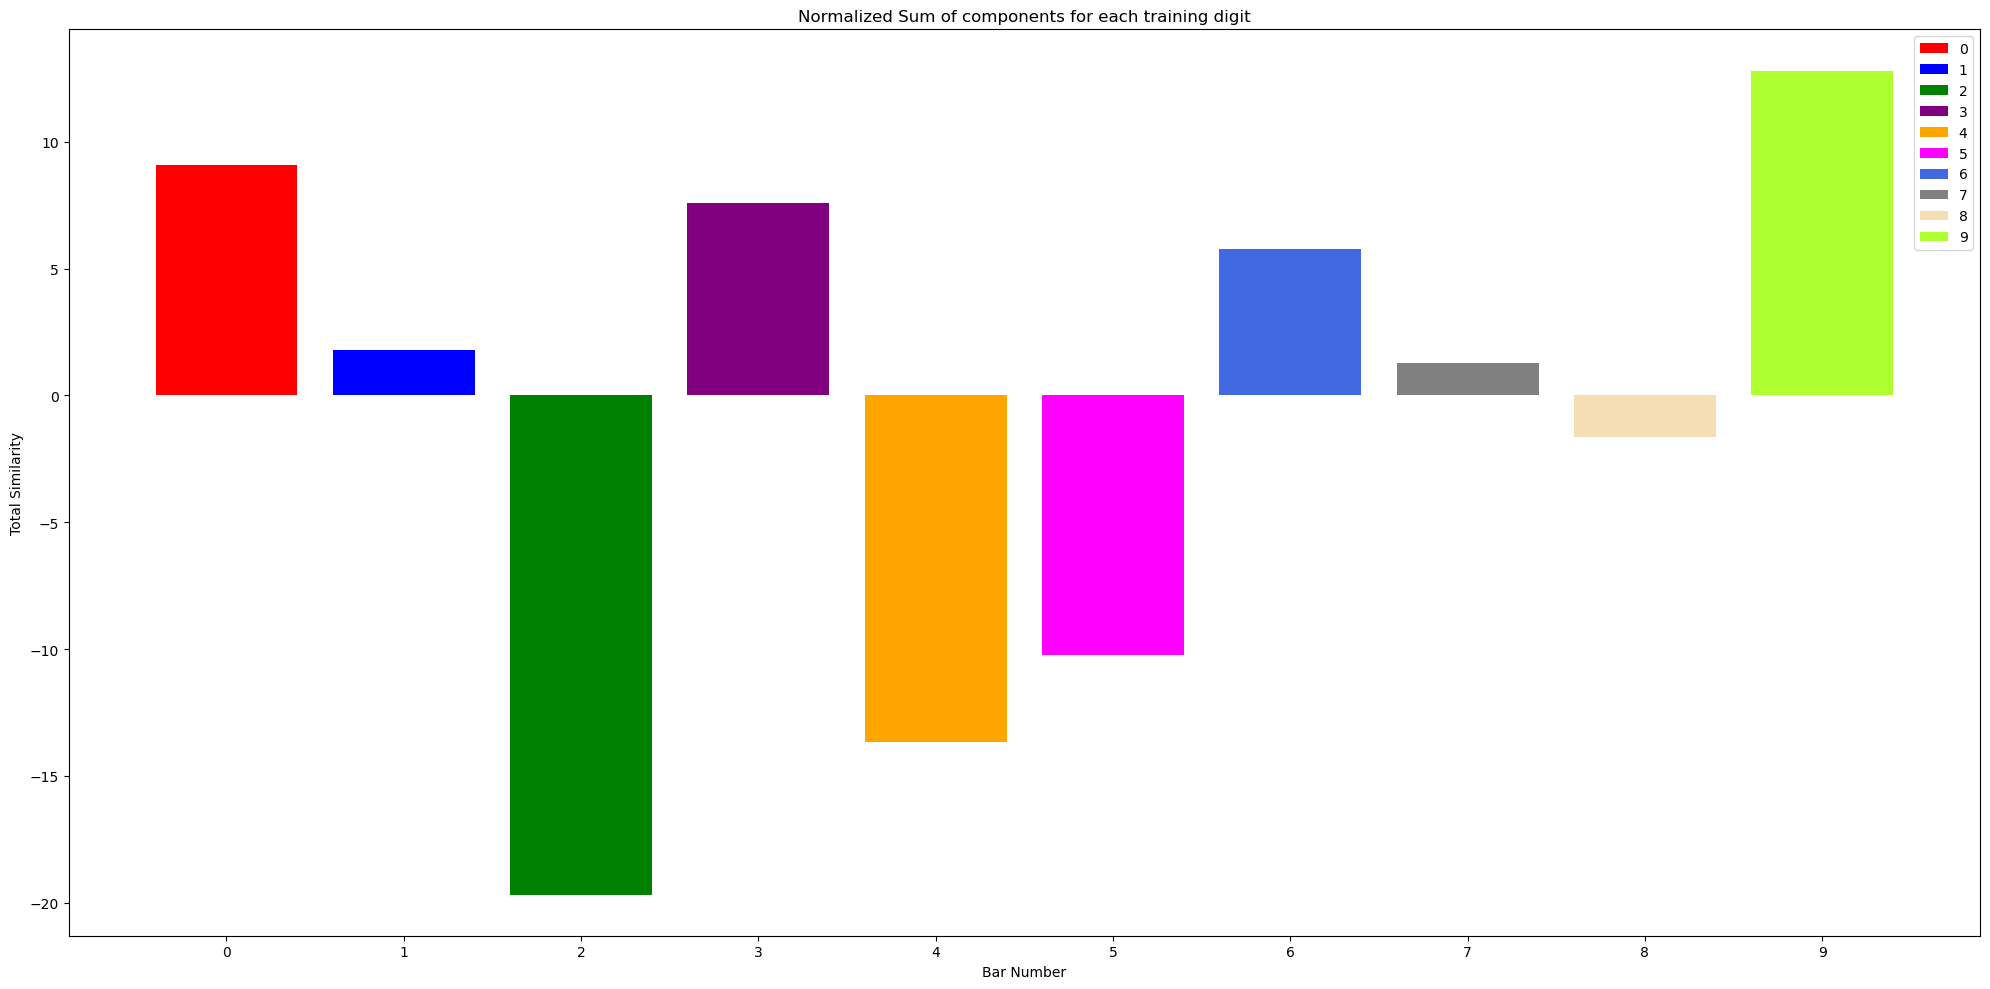

In [42]:
# Find the index of a sample representing some digit.
digit_desired = 3
index_of_interest = np.random.choice(np.where(y_te_org == digit_desired)[0])
comps = components[:, index_of_interest]

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['red', 'blue', 'green', 'purple', 'orange', 'magenta', 'royalblue', 'gray', 'wheat', 'greenyellow']
vals = [0]*len(colors)
label_counts = dict(zip(labels, vals))

for ix, ind in enumerate(y_tr_org):
    label_counts[str(ind)] += comps[ix]

vals = list(label_counts.values())
plt.figure(figsize=(20, 10))  # Optional: set the figure size
plt.bar(labels, vals, color = colors, label = labels)
plt.xlabel('Bar Number')
plt.ylabel('Total Similarity')
plt.title('Normalized Sum of components for each training digit')
plt.legend()
plt.tight_layout()
plt.show()

<u>__References__<u>

__[1]__ Emmanuel J. Candes; Xiaodong Li; Yi Ma; John Wright (2009). "Robust Principal Component Analysis?". Journal of the ACM. 58 (3): 1–37

__[2]__ Steven L. Brunton; J. Nathan Kutz (2019). "Data Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control". Section 3.7 

__[3]__ Hestenes, M. R. (1969). "Multiplier and gradient methods". Journal of Optimization Theory and Applications. 4 (5): 303–320.

__[4]__ MNIST Dataset as provided by TensorFlow. https://www.tensorflow.org/datasets/catalog/mnist